# Training

In [ ]:
!pip install git+https://github.com/PatBall1/detectree2.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PatBall1/detectree2.git to /tmp/pip-req-build-vm6h3yhf
  Running command git clone -q https://github.com/PatBall1/detectree2.git /tmp/pip-req-build-vm6h3yhf
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-install-8q9hv6h0/detectron2_7b2521c5c0ae4f318255eccaf319ca8f
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-install-8q9hv6h0/detectron2_7b2521c5c0ae4f318255eccaf319ca8f
     |████████████████████████████████| 274 kB 8.3 MB/s 
     |████████████████████████████████| 400 kB 46.2 MB/s 
     |████████████████████████████████| 48 kB 291 kB/s 
     |████████████████████████████████| 2.1 MB 42.7 MB/s 
     |████████████████████████████████| 1.0 MB 43.8 MB/s 
     |████████████████████████████████| 19.3 MB 463 kB/s 
     |████████████████████████████████| 16.7 MB 34.4 MB/s 
     |███████████████████

In [22]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectree2.models.train import get_tree_dicts
import random
from PIL import Image
import os
# necessary libraries
import pandas as pd
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import json
import glob

In [2]:
# train_location = "/content/drive/Shareddrives/detectree2/data/Paracou/tiles/data/train/"
train_location = "/rds/project/rds-5mCMIDBOkPU/ma595/detectree2/output2/paracou/train/"
root_dir = '/rds/project/rds-5mCMIDBOkPU/ma595/detectree2/output2/paracou/'
#train_dirs = os.listdir(train_location)
train_dirs = [os.path.join(train_location, dir) for dir in os.listdir(train_location)]
train_dirs

['/rds/project/rds-5mCMIDBOkPU/ma595/detectree2/output2/paracou/train/fold_3',
 '/rds/project/rds-5mCMIDBOkPU/ma595/detectree2/output2/paracou/train/fold_5',
 '/rds/project/rds-5mCMIDBOkPU/ma595/detectree2/output2/paracou/train/fold_1',
 '/rds/project/rds-5mCMIDBOkPU/ma595/detectree2/output2/paracou/train/fold_2',
 '/rds/project/rds-5mCMIDBOkPU/ma595/detectree2/output2/paracou/train/fold_4']

In [3]:
def combine_dicts(folder, val_folder):
    train_dirs = [os.path.join(folder, file) for file in os.listdir(folder)]
    del train_dirs[(val_folder-1)]
    tree_dicts = []
    for d in train_dirs:
        tree_dicts = tree_dicts + get_tree_dicts(d)
    return tree_dicts
dicts = combine_dicts(train_location, 1)  
len(dicts)

21

In [4]:
for d in [train_location]:
    DatasetCatalog.register("trees_train1", lambda d=d: combine_dicts(d, 1))
    MetadataCatalog.get("trees_train1").set(thing_classes=['tree'])

In [5]:
for d in ['test']:
    DatasetCatalog.register("trees_test1", lambda d=d: get_tree_dicts(root_dir + d))
    MetadataCatalog.get("trees_test1").set(thing_classes=['tree'])

In [6]:
trees_metadata = MetadataCatalog.get("trees_train1")
trees_metadata

namespace(name='trees_train1', thing_classes=['tree'])

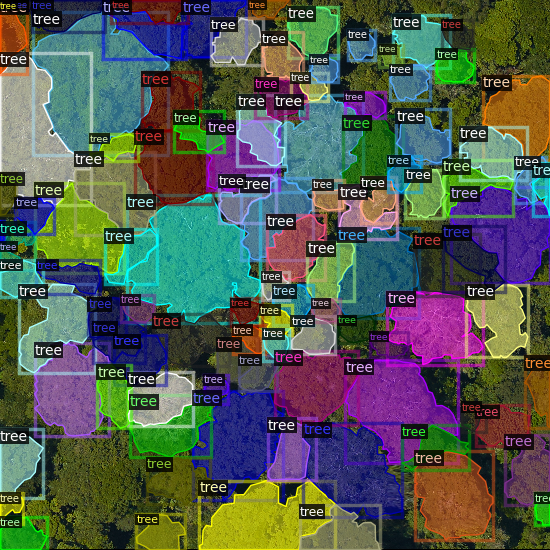

In [7]:
from detectron2.utils.visualizer import Visualizer
import cv2
dataset_dicts = combine_dicts(train_location, 1)
#dataset_dicts = get_tree_dicts("./")
for d in dataset_dicts:
#     print(d)
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=trees_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    image = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)
    display(Image.fromarray(image))
    break

In [8]:
from detectree2.models.train import get_tree_dicts
import time

def dataset_function(folder):
    tree_dicts = []
    for d in train_dirs:
        tree_dicts = tree_dicts + get_tree_dicts(d)
    #time.sleep(1)
    return tree_dicts
# print(tree_dicts)

In [9]:
len(tree_dicts)

NameError: name 'tree_dicts' is not defined

In [10]:
del train_dirs[0]
train_dirs

['/rds/project/rds-5mCMIDBOkPU/ma595/detectree2/output2/paracou/train/fold_5',
 '/rds/project/rds-5mCMIDBOkPU/ma595/detectree2/output2/paracou/train/fold_1',
 '/rds/project/rds-5mCMIDBOkPU/ma595/detectree2/output2/paracou/train/fold_2',
 '/rds/project/rds-5mCMIDBOkPU/ma595/detectree2/output2/paracou/train/fold_4']

In [11]:
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

In [12]:
### Setup the evaluator

from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    verify_results,
)

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


In [13]:
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader, build_detection_train_loader
import detectron2.utils.comm as comm
#import torch
import time
import datetime

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

In [14]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
import detectron2.data.transforms as T
from detectron2.data import detection_utils as utils

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            os.makedirs("eval_2", exist_ok=True)
            output_folder = "eval_2"
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=DatasetMapper(cfg, is_train=True, augmentations=[T.Resize((800, 800)), T.RandomBrightness(0.8, 1.8), 
        T.RandomContrast(0.6, 1.3), T.RandomSaturation(0.8, 1.4), T.RandomRotation(angle=[90, 90], expand=False), T.RandomLighting(0.7),
        T.RandomFlip(prob=0.4, horizontal=False, vertical=True)]))

In [15]:
# just setting up the cfg file

from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("trees_train1",)
cfg.DATASETS.TEST = ("trees_test1",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 900
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/home/ma595/install/install-rds/miniconda3/envs/my_project_env/lib/python3.9/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/home/ma595/install/install-rds/miniconda3/envs/my_project_env/lib/python3.9/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
AttributeError: _evt


In [23]:
### need to rewrite this to not use DefaultTrainer/DefaultPredictor. This will allow extraction of masks more easily. Pay attention to this. 18/6/21
### have now done this. I am sick.
# Train! Can change hyperparameters e.g. learning rate
# This works excellently, 15/6/21
# from detectree2.models.train import MyTrainer
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
import torch

import logging

from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("trees_train1",)
cfg.DATASETS.TEST = ("trees_test1",)
cfg.DATALOADER.NUM_WORKERS = 2
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")

# load our pre-trained model if you like
# cfg.MODEL.WEIGHTS = 'gdrive/MyDrive/JamesHirst/model_final.pth'

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0005
# cfg.SOLVER.WARMUP_ITERS = 500
cfg.SOLVER.MAX_ITER = 1000
# cfg.SOLVER.STEPS = (250,)
# cfg.SOLVER.GAMMA = 0.5
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

### From here is the important bit that hasn't been repeated further up
#cfg.TEST.EVAL_PERIOD = 100

# make clear where the output file each time

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)



trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()
#eval_results = inference_on_dataset(trainer.model, val_loader, DatasetEvaluators(evaluator))



[06/27 23:12:57 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[06/27 23:12:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [Resize(shape=(800, 800)), RandomBrightness(intensity_min=0.8, intensity_max=1.8), RandomContrast(intensity_min=0.6, intensity_max=1.3), RandomSaturation(intensity_min=0.8, intensity_max=1.4), RandomRotation(angle=[90, 90], expand=False), RandomLighting(scale=0.7), RandomFlip(prob=0.4, horizontal=False, vertical=True)]
[06/27 23:12:57 d2.data.build]: Removed 0 images with no usable annotations. 21 images left.
[06/27 23:12:57 d2.data.build]: Using training sampler TrainingSampler
[06/27 23:12:57 d2.data.common]: Serializing 21 elements to byte tensors and concatenating them all ...
[06/27 23:12:57 d2.data.common]: Serialized dataset takes 1.97 MiB
WARNING [06/27 23:12:57 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.
[06/27 23:12:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_lengt

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

[06/27 23:13:08 d2.engine.train_loop]: Starting training from iteration 0
[06/27 23:13:11 d2.utils.events]:  eta: 0:02:02  iter: 19  total_loss: 3.01  loss_cls: 0.7666  loss_box_reg: 0.3373  loss_mask: 0.6927  loss_rpn_cls: 0.6879  loss_rpn_loc: 0.5149  time: 0.1253  data_time: 0.0268  lr: 9.9905e-06  max_mem: 3723M
[06/27 23:13:14 d2.utils.events]:  eta: 0:01:58  iter: 39  total_loss: 2.795  loss_cls: 0.5628  loss_box_reg: 0.3733  loss_mask: 0.6856  loss_rpn_cls: 0.6803  loss_rpn_loc: 0.4868  time: 0.1234  data_time: 0.0057  lr: 1.998e-05  max_mem: 3723M
[06/27 23:13:16 d2.utils.events]:  eta: 0:01:56  iter: 59  total_loss: 2.728  loss_cls: 0.5605  loss_box_reg: 0.3865  loss_mask: 0.6729  loss_rpn_cls: 0.6655  loss_rpn_loc: 0.4532  time: 0.1241  data_time: 0.0092  lr: 2.997e-05  max_mem: 3723M
[06/27 23:13:19 d2.utils.events]:  eta: 0:01:54  iter: 79  total_loss: 2.736  loss_cls: 0.5444  loss_box_reg: 0.4262  loss_mask: 0.6643  loss_rpn_cls: 0.6504  loss_rpn_loc: 0.4485  time: 0.1242 

[06/27 23:14:31 d2.utils.events]:  eta: 0:00:42  iter: 659  total_loss: 2.208  loss_cls: 0.3675  loss_box_reg: 0.6056  loss_mask: 0.5479  loss_rpn_cls: 0.3247  loss_rpn_loc: 0.344  time: 0.1243  data_time: 0.0041  lr: 0.00032967  max_mem: 3723M
[06/27 23:14:34 d2.utils.events]:  eta: 0:00:39  iter: 679  total_loss: 2.178  loss_cls: 0.3735  loss_box_reg: 0.606  loss_mask: 0.5466  loss_rpn_cls: 0.3338  loss_rpn_loc: 0.3246  time: 0.1243  data_time: 0.0036  lr: 0.00033966  max_mem: 3723M
[06/27 23:14:36 d2.utils.events]:  eta: 0:00:37  iter: 699  total_loss: 2.238  loss_cls: 0.3959  loss_box_reg: 0.6385  loss_mask: 0.5458  loss_rpn_cls: 0.3298  loss_rpn_loc: 0.3192  time: 0.1243  data_time: 0.0047  lr: 0.00034965  max_mem: 3723M
[06/27 23:14:39 d2.utils.events]:  eta: 0:00:34  iter: 719  total_loss: 2.218  loss_cls: 0.3814  loss_box_reg: 0.6416  loss_mask: 0.5487  loss_rpn_cls: 0.3109  loss_rpn_loc: 0.3248  time: 0.1243  data_time: 0.0049  lr: 0.00035964  max_mem: 3723M
[06/27 23:14:41 d2

[06/27 23:15:17 d2.engine.defaults]: Evaluation results for trees_test1 in csv format:
[06/27 23:15:17 d2.evaluation.testing]: copypaste: Task: bbox
[06/27 23:15:17 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[06/27 23:15:17 d2.evaluation.testing]: copypaste: 9.5605,26.8062,3.6192,0.5977,6.5930,19.0734
[06/27 23:15:17 d2.evaluation.testing]: copypaste: Task: segm
[06/27 23:15:17 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[06/27 23:15:17 d2.evaluation.testing]: copypaste: 6.1142,21.8726,1.0536,0.0396,3.1908,13.6327
